In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import importlib

import pre_processing

In [162]:
auction_data_path = "../Data/data_files/df_PRL_SRL_TRL_bids.parquet"
mfrr_activation_price_path = "../Data/data_files/df_TRE_Tertiary_Control_Energy_bids.parquet"
dayahead_price_path = "../Data/data_files/df_dayahead_randomized.parquet"
imbalance_price_path = "../Data/data_files/df_imbalance_penalty_oneprice.parquet"
imbalance_volume_path = "../Data/data_files/df_imbalance_volume_ch.parquet"

auction_data = pd.read_parquet(auction_data_path)
mfrr_activation_price = pd.read_parquet(mfrr_activation_price_path)
dayahead_price = pd.read_parquet(dayahead_price_path).reset_index()
dayahead_price['time'] = pd.to_datetime(dayahead_price['time'], utc=True)
imbalance_price = pd.read_parquet(imbalance_price_path)
imbalance_volume = pd.read_parquet(imbalance_volume_path)
imbalance_data = pd.merge(imbalance_volume, imbalance_price, on='time', how='inner').reset_index()
imbalance_data['time'] = pd.to_datetime(imbalance_data['time'], utc=True)

In [166]:
def test(time, time_utc):
    volume = imbalance_data.loc[imbalance_data['time'] == pd.to_datetime(time_utc), 'imbalance_volume_ch'].values[0]

    aFRR_data, mFFR_weekly_data, mFFR_daily_data = get_bid_profiles(auction_data, time, volume)
    mFRR_data = get_mFFR_profile(mFFR_weekly_data, mFFR_daily_data)

    wap_aFRR = compute_WAP(0.95*volume, aFRR_data)
    wap_mFRR = 2 * compute_WAP(0.05 * 0.5 * volume, mFRR_data)

    spot_price = get_spot_price(dayahead_price, pd.to_datetime(time_utc).floor('h'))
    imbalance_penalty = compute_imbalance_price(volume, wap_mfrr=wap_mFRR, wap_afrr=wap_aFRR, spot=spot_price)
    imbalance_price_pred = imbalance_penalty
    imbalance_price_act = imbalance_data.loc[imbalance_data['time'] == pd.to_datetime(time_utc), 'price_imbalance_penalty'].values[0]

    return volume, imbalance_price_pred, imbalance_price_act

In [183]:
importlib.reload(pre_processing)
from pre_processing import *

months = [2, 7, 10]

res = {month: np.zeros((24*4, 3)) for month in months}

for month in months:
    for i in range(24*4):
        time_utc = pd.to_datetime(f"2023-{month}-15", utc=True) + pd.Timedelta(minutes=15*i)
        time = parse_utc_to_time_info(time_utc)
        volume, imbalance_price_pred, imbalance_price_act = test(time,time_utc)

        res[month][i] = (volume, imbalance_price_pred, imbalance_price_act)

[-1.12940655  2.42332526  2.52080035  3.01688933 -1.2921489  -1.201584
 -2.59123431  3.58489157  1.42752137  1.31973505  0.78833036  0.7488937
  0.705705    1.00267236  1.30095516 -0.72353546 -0.27550579 -1.79459855
 -0.80854787 -1.38450935  1.85312619  3.43725859  1.46279666  1.77407717
  0.89831597 -2.37571309 -2.60162435 -2.67060214 -2.79366214 -2.78691112
 -2.55669146 -1.12864103 -2.76       -3.98       -1.82       -1.66025911
 -5.1        -4.64       -1.51        0.46       -6.4        -6.96
 -0.88        8.86       -0.6        -0.9         9.98479057 10.77231857
 12.55632918  8.35692243 14.53        7.04846572 -1.14216082 -1.91893065
 -1.32       -3.15        2.55325715  2.26100335 -3.53       -4.12
  6.31983682 -0.8787325  -3.77       -6.61       -1.69655106 -3.47
 -5.7        -8.79       -5.47       -3.34       -2.03       -1.27932466
 -5.49       -4.8        -2.46       -1.46682851 -7.96       -8.2
 -1.329931   -0.05117205 -7.72       -0.32       -0.43850276  0.48517202
 -5.62

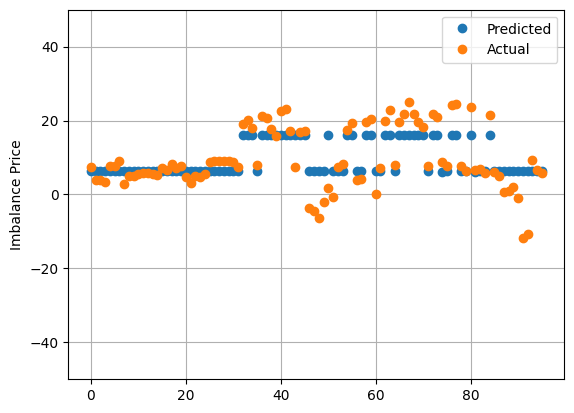

In [189]:
for month in months:
    if month == 10:
        output = res[month]
        pd.DataFrame(output).to_csv(f'result_{month}.csv', index=False)

        # compute root mean square error using numpy package
        temp = (output[:,1] - output[:,2])
        print(temp)
        rmse = np.sqrt(np.mean(temp**2))
        mae = np.mean(np.abs(temp))
        print(f'MAE for month {month}: {mae}')
        print(f'RMSE for month {month}: {rmse}')

        fig = plt.figure()
        plt.plot([x[1] for x in res[month]], 'o', label='Predicted')
        plt.plot([x[2] for x in res[month]], 'o', label='Actual')
        # plt.xlabel('Imbalance Volume')
        plt.ylabel('Imbalance Price')
        plt.ylim(-50, 50)
        plt.legend()
        plt.grid(True)
        plt.show()